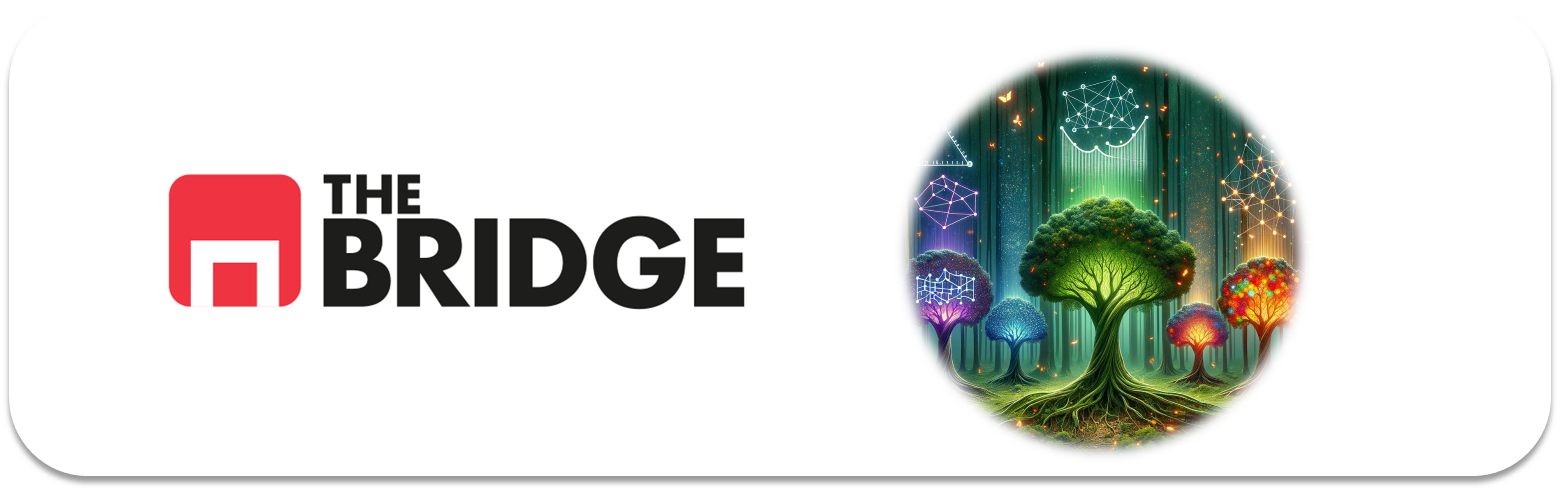

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import random

np.random.seed(42)
random.seed(42)

import pandas as pd

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyClassifier

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [64]:
df_bank = pd.read_csv('data/bank-full.csv', sep=';')
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Target: 
y - has the client subscribed a term deposit? (binary: "yes","no")

In [65]:
target ="y"

In [66]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Data Preparation

In [67]:
print(df_bank['month'].unique())

['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']


In [68]:
# Change yes/no categorical data to 1/0 
for f in ['default', 'housing', 'loan', 'y']:
    df_bank[f] = pd.Series(np.where(df_bank[f].values == 'yes', 1, 0), df_bank.index)

# Replace month names with numeric month

months = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
df_bank['month'] = df_bank['month'].apply(lambda x : months[x])

In [69]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,5,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,5,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,5,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,5,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,5,198,1,-1,0,unknown,0


/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/405260728.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_bank['y'], palette="Blues")


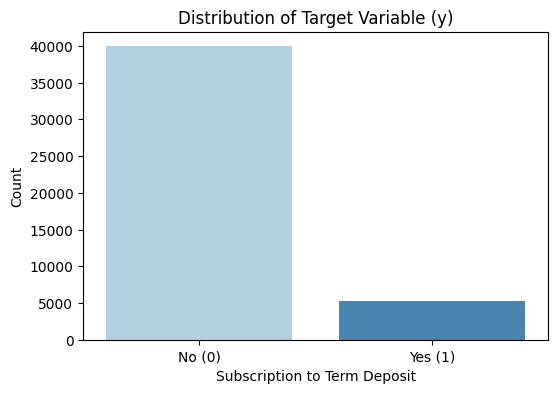

y
0    0.883015
1    0.116985
Name: proportion, dtype: float64

In [70]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df_bank['y'], palette="Blues")
plt.title("Distribution of Target Variable (y)")
plt.xticks(ticks=[0, 1], labels=['No (0)', 'Yes (1)'])
plt.xlabel("Subscription to Term Deposit")
plt.ylabel("Count")
plt.show()


df_bank['y'].value_counts(normalize=True)

## Mini-EDA

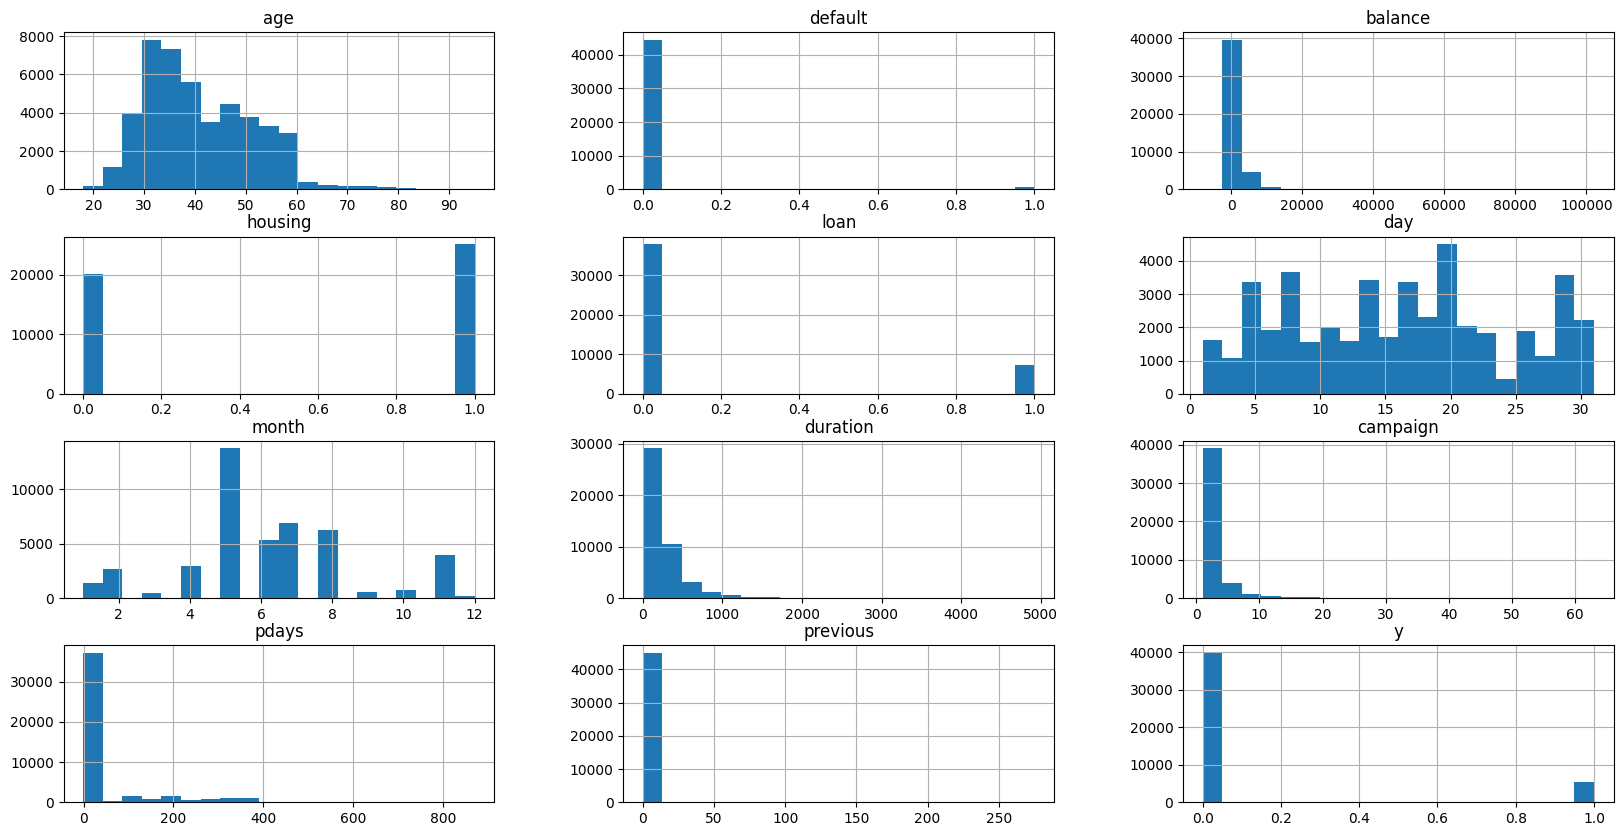

In [71]:
df_bank.hist(bins=20, figsize=(20,10));

### Categorical features and the target 

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=45)
/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=45)


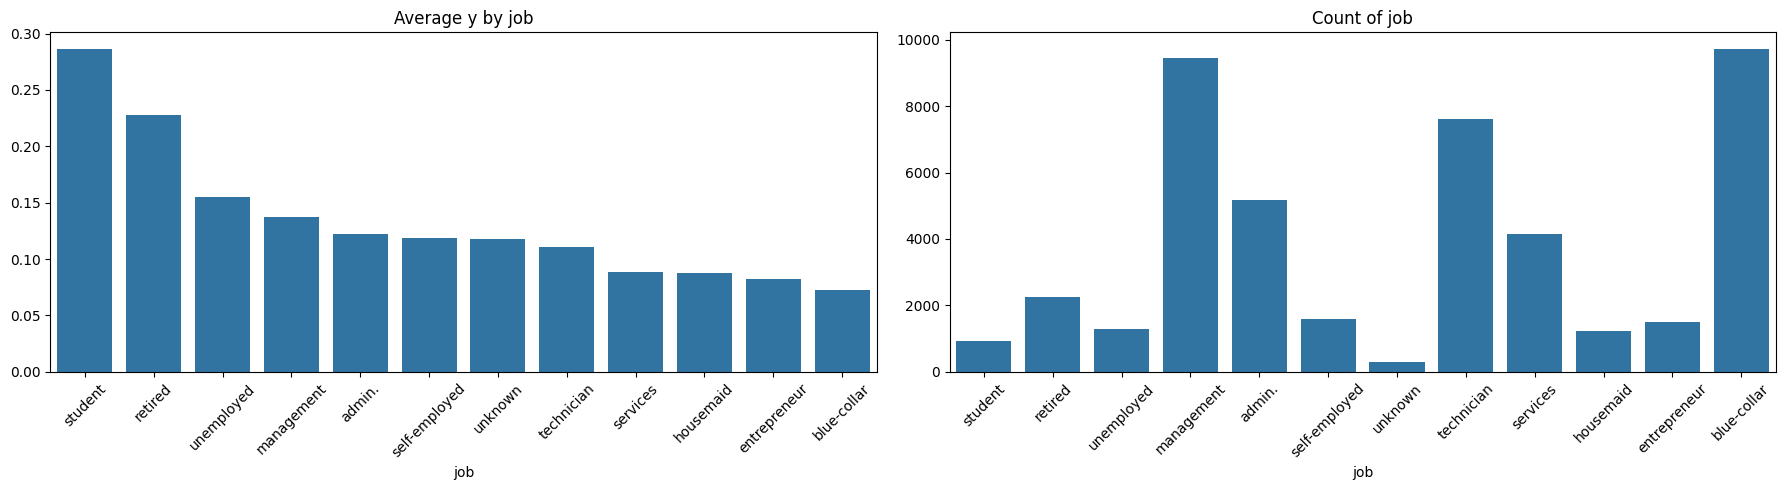

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=45)
/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=45)


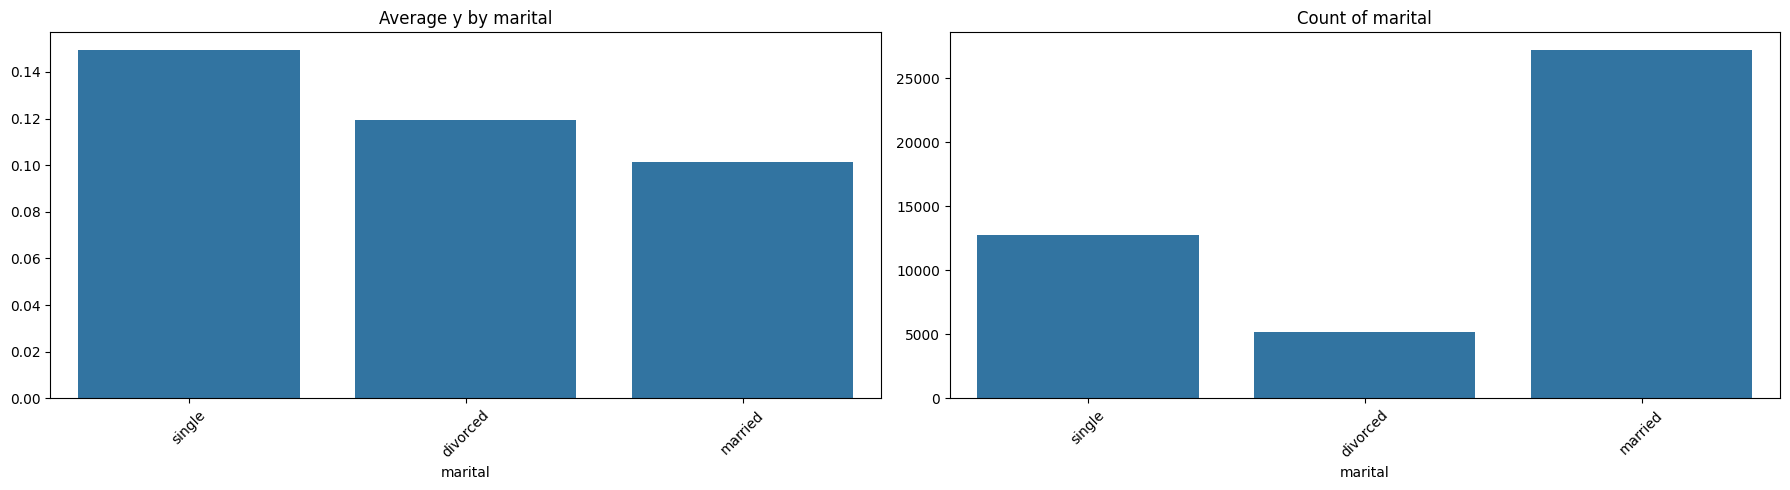

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=45)
/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=45)


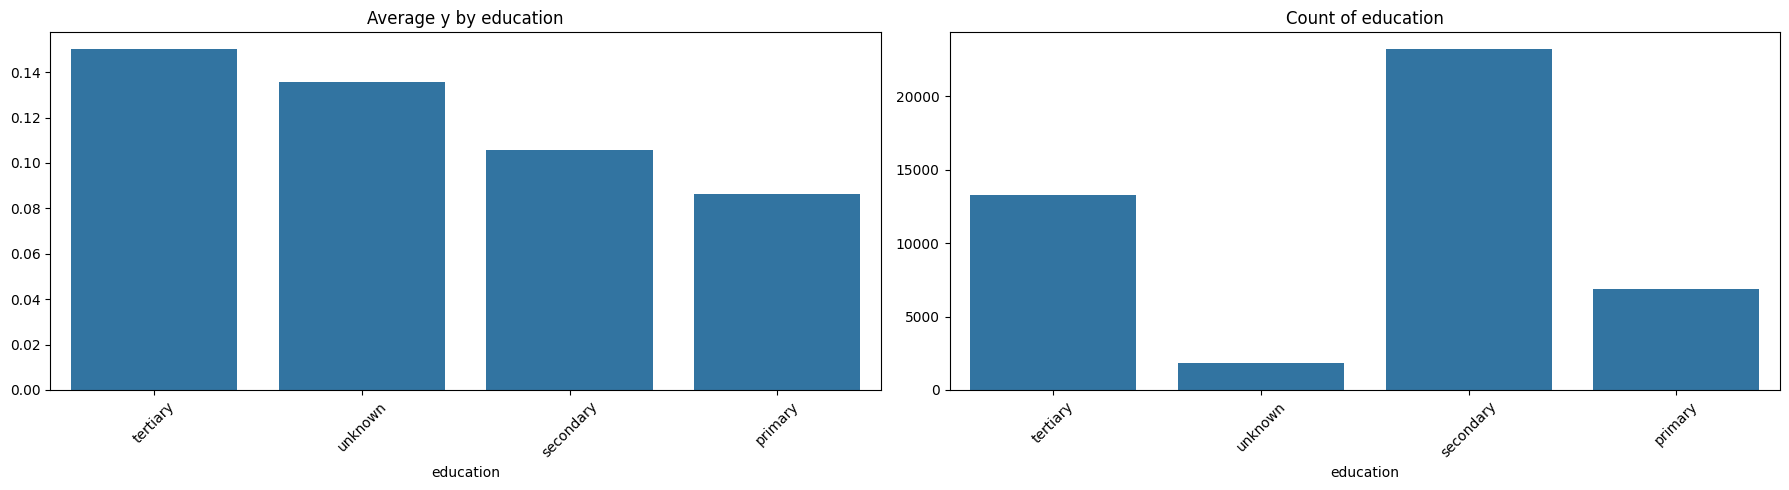

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=45)
/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=45)


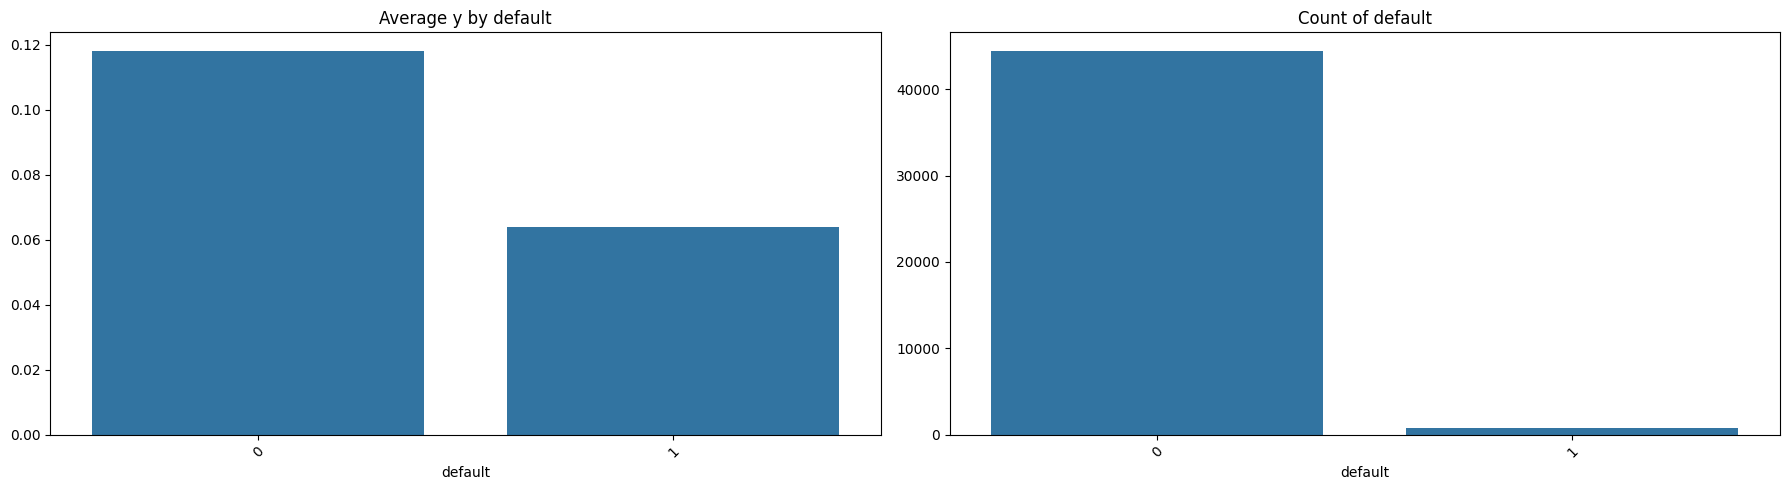

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=45)
/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=45)


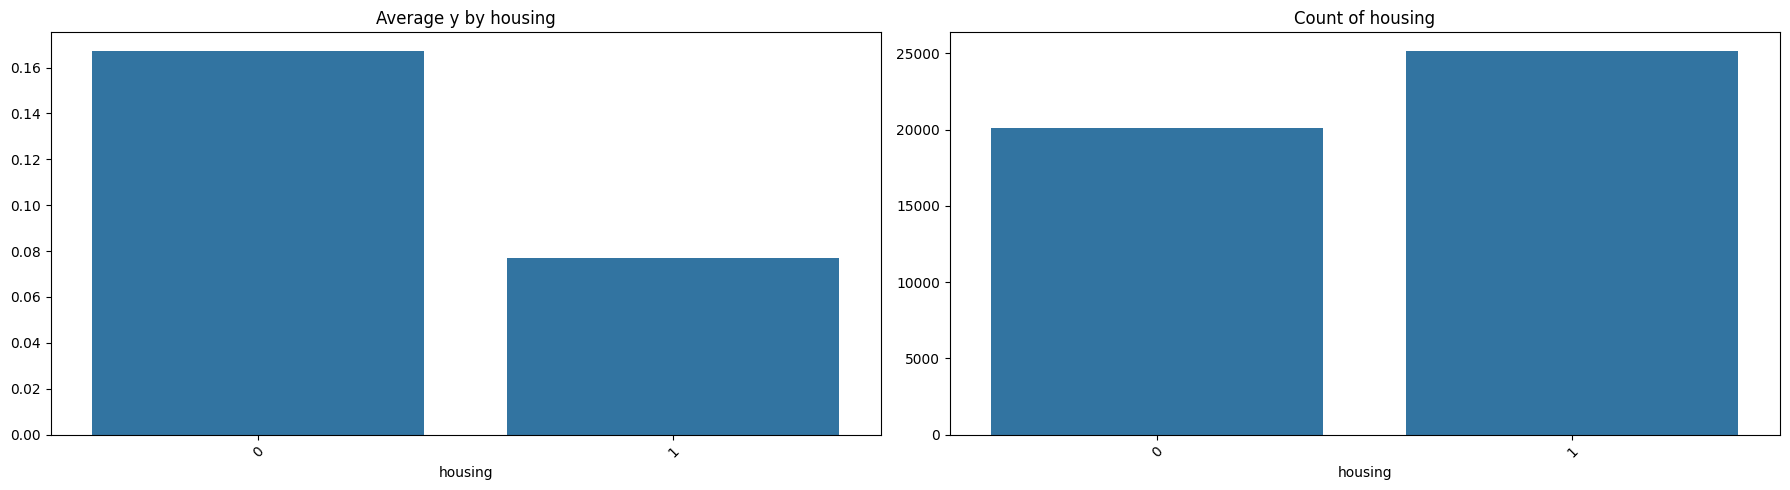

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=45)
/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=45)


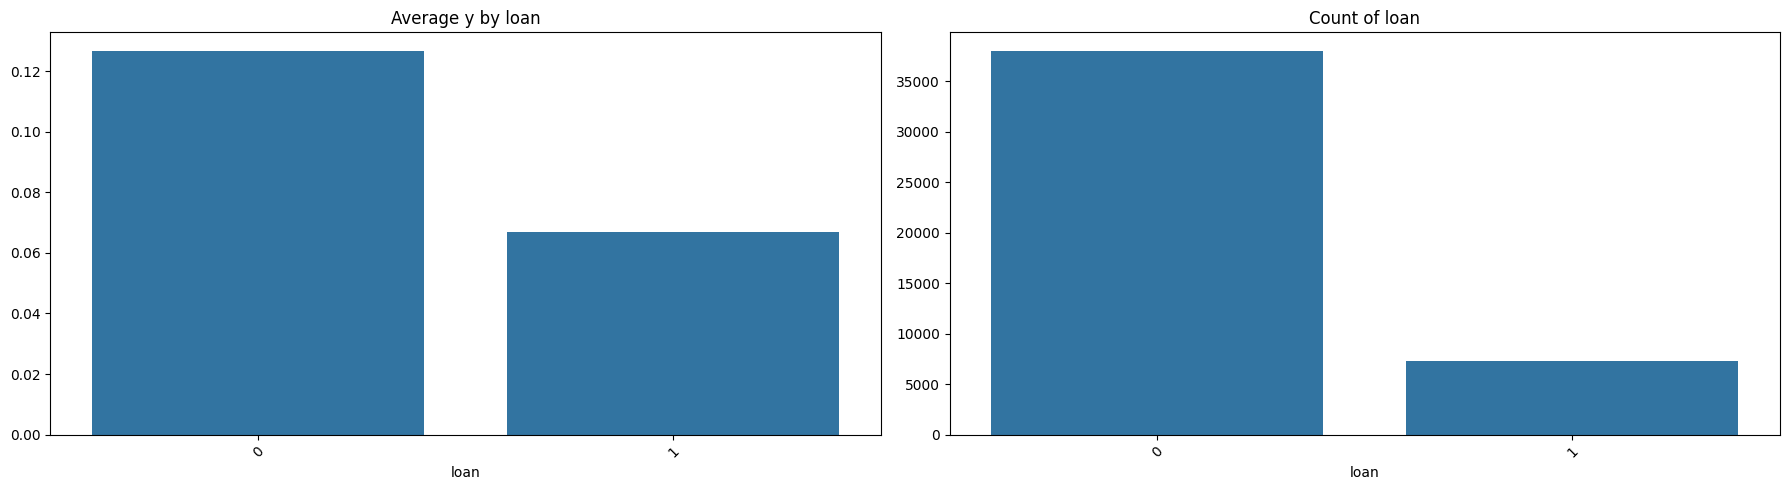

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=45)
/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=45)


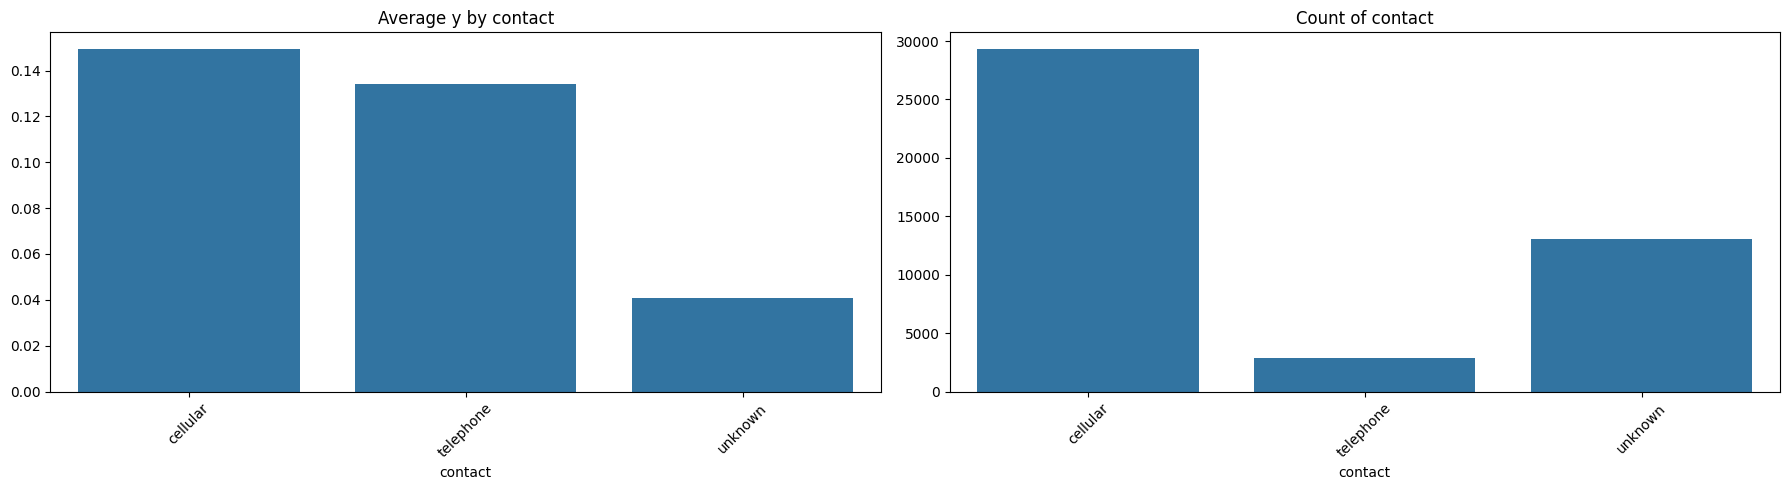

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=45)
/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=45)


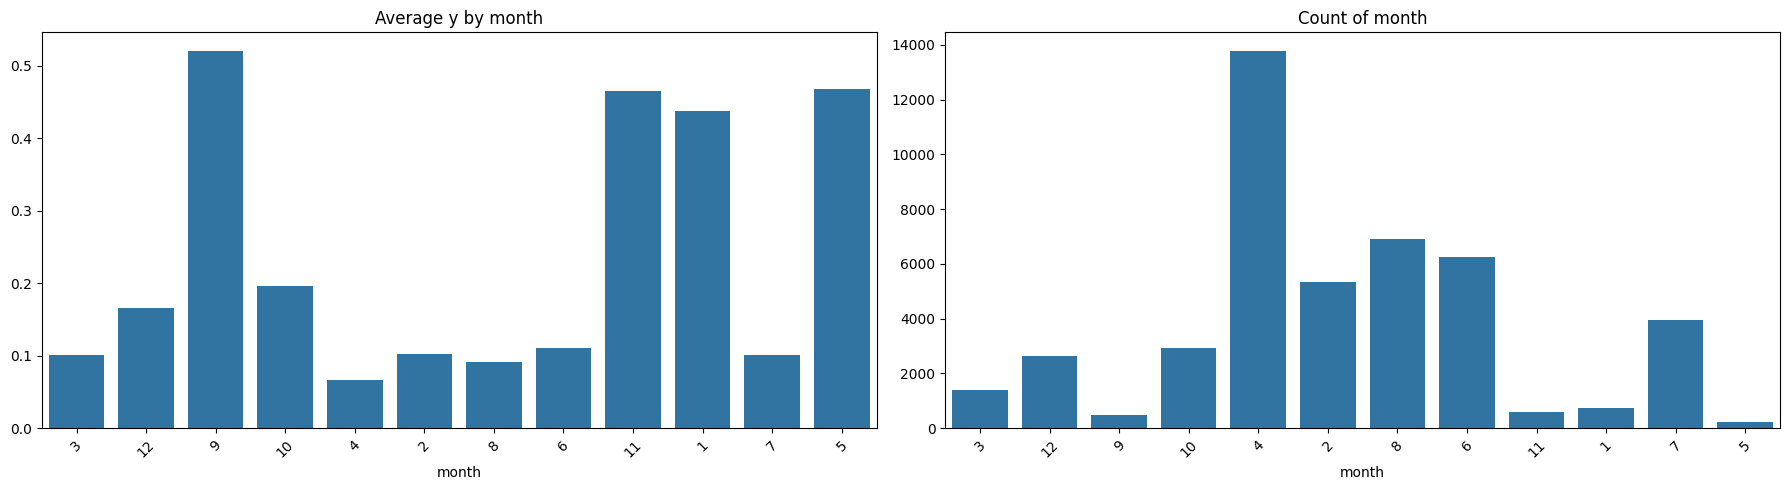

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=45)
/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_95602/314889060.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=45)


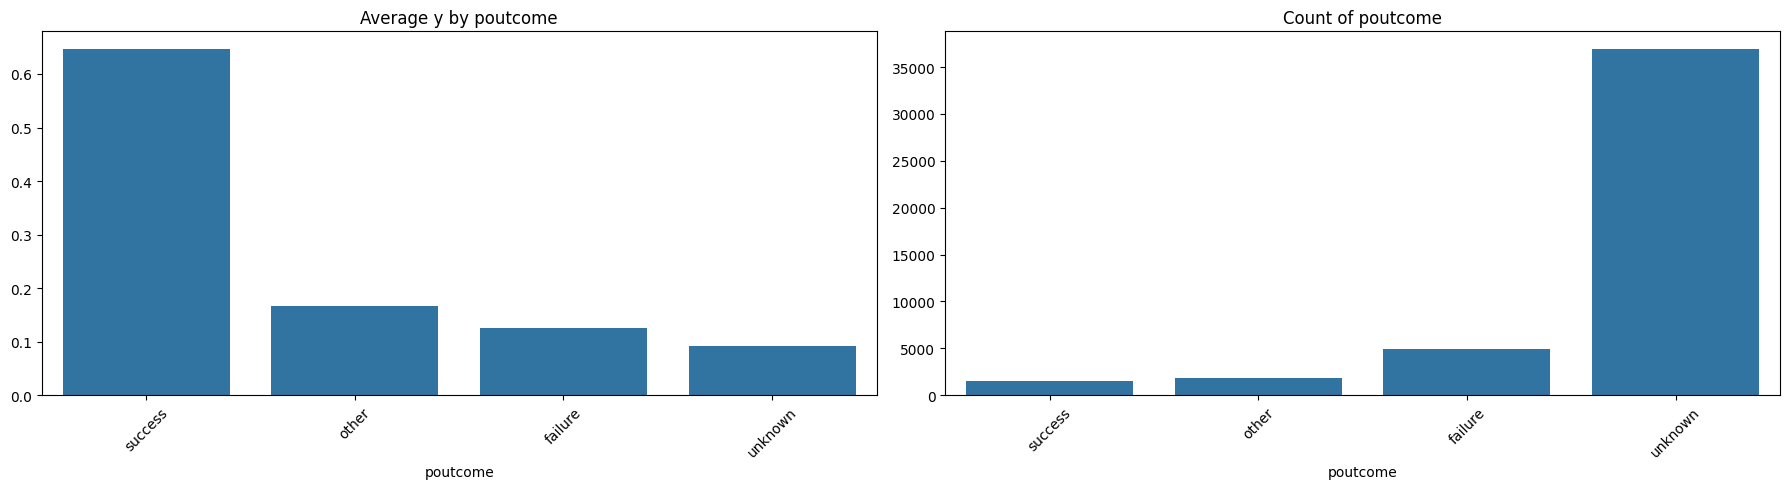

In [72]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for f in cat_features:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))  

   
    group = df_bank.groupby(f)['y'].mean().sort_values(ascending=False)
    labels = group.index.tolist()
    sns.barplot(x=group.index, y=group.values, ax=axes[0])
    axes[0].set_title(f'Average y by {f}')
    axes[0].set_xticklabels(labels, rotation=45)

 
    count_data = df_bank.groupby(f)['y'].count().reindex(labels)  
    sns.barplot(x=count_data.index, y=count_data.values, ax=axes[1])
    axes[1].set_title(f'Count of {f}')
    axes[1].set_xticklabels(labels, rotation=45)

    plt.tight_layout()  # Adjust layout
    plt.show()

### Correlation of numerical features

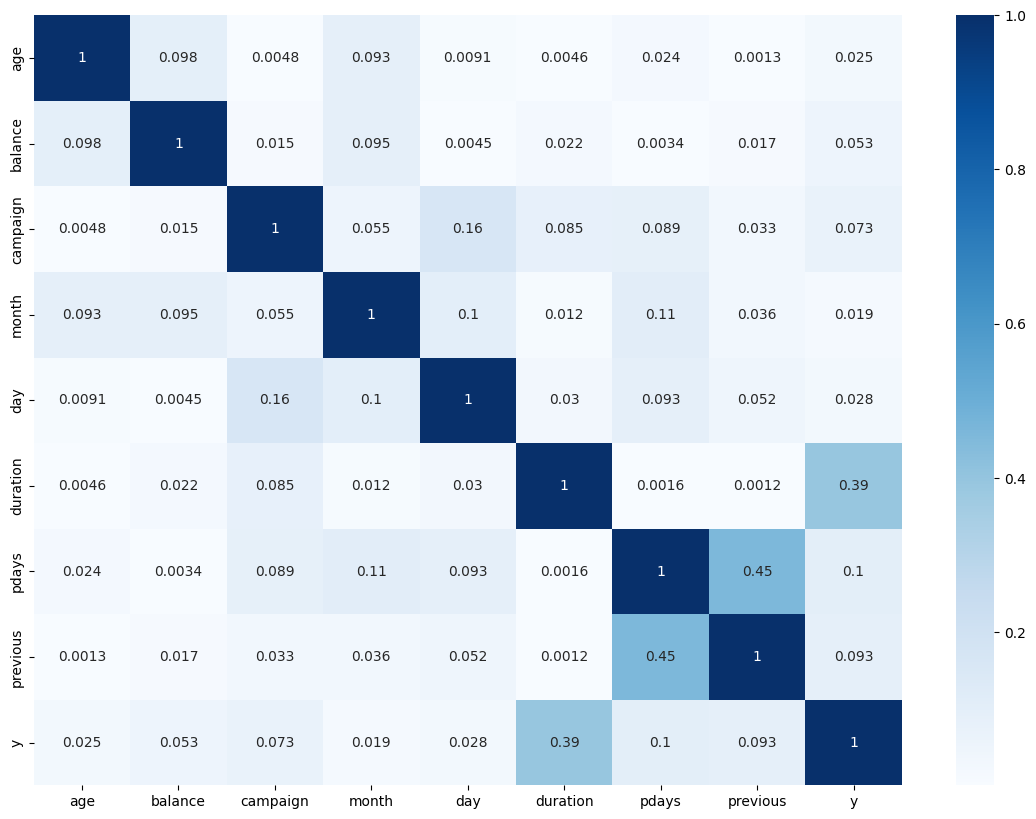

In [73]:
num_features = ['age', 'balance', 'campaign', 'month', 'day', 'duration', 'pdays', 'previous']
num_features_y = num_features + ['y']

plt.figure(figsize=(14,10))
sns.heatmap(np.abs(df_bank[num_features_y].corr()), annot=True, cmap="Blues",)
plt.show()

In [74]:
df_bank[num_features].corrwith(df_bank['y']).sort_values(ascending=False)

duration    0.394521
pdays       0.103621
previous    0.093236
balance     0.052838
age         0.025155
month       0.018717
day        -0.028348
campaign   -0.073172
dtype: float64

### Transforming categorical features to numerical

In [75]:
from sklearn.preprocessing import LabelEncoder
cat_features_1 = ['job', 'marital', 'education', 'contact', 'poutcome']
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df_bank[col] = le.fit_transform(df_bank[col])
    label_encoders[col] = le  # Store encoder for possible future use


In [76]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,4,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,4,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,4,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,4,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,4,198,1,-1,0,3,0


## Splliting into Train and Test sets

In [77]:
X = df_bank.drop(columns=[target])
y = df_bank[target]  


train_set, test_set = train_test_split(df_bank, test_size=0.2, random_state=42, stratify=df_bank[target])


X_train = train_set.drop(columns=[target])
y_train = train_set[target]

X_test = test_set.drop(columns=[target])
y_test = test_set[target]

### Training with Logisitic regression to set a baseline

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [79]:

y_pred_log = log_reg.predict(X_test)

log_reg_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_log),
    "Precision": precision_score(y_test, y_pred_log),
    "Recall": recall_score(y_test, y_pred_log),
    "F1 Score": f1_score(y_test, y_pred_log)
}

log_reg_metrics

{'Accuracy': 0.8887537321685282,
 'Precision': 0.5656565656565656,
 'Recall': 0.21172022684310018,
 'F1 Score': 0.3081155433287483}

### Decision Tree Model

In [81]:
tree = DecisionTreeClassifier(random_state=42)


param_dist = {
    'criterion': ['gini', 'entropy'],  
    'max_depth': [5, 10, 15, None],    
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 5, 10]     
}

In [83]:
# Perform Randomized Search with cross-validation (5-fold) and 20 random iterations
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    tree, param_dist, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, None],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='f1', verbose=1)

In [84]:

best_tree_model = random_search.best_estimator_
best_params = random_search.best_params_


In [86]:
# Make predictions on the test set
y_pred_tree = best_tree_model.predict(X_test)


tree_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_tree),
    "Precision": precision_score(y_test, y_pred_tree),
    "Recall": recall_score(y_test, y_pred_tree),
    "F1 Score": f1_score(y_test, y_pred_tree)
}

print("\n Best Decision Tree Parameters:")
print(best_params)

print("\nDecision Tree Performance:")
print(tree_metrics)



 Best Decision Tree Parameters:
{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}

Decision Tree Performance:
{'Accuracy': 0.8971580227800509, 'Precision': 0.5723981900452488, 'Recall': 0.4782608695652174, 'F1 Score': 0.5211122554067971}


                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.888754   0.565657  0.211720  0.308116
Decision Tree        0.897158   0.572398  0.478261  0.521112


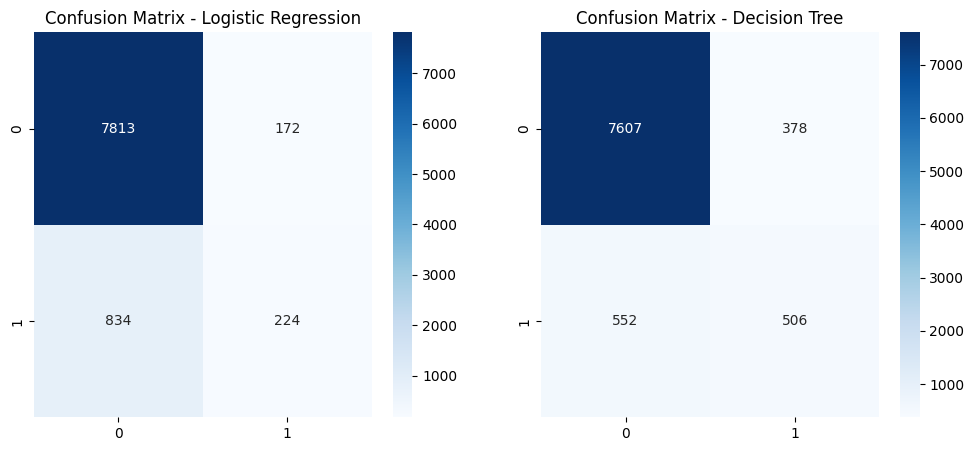

In [87]:
# 📌 Model Comparison
comparison = pd.DataFrame([log_reg_metrics, tree_metrics], index=['Logistic Regression', 'Decision Tree'])
print(comparison)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic Regression")

# Decision Tree Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Decision Tree")

plt.show()